# Compare Snow Depths with Interferogram

**Goal**: Compare the insar phase to snowdepths

**Approach**: 
1. Define an area to study the relationship 
2. Grab the snow depths from the magnaprobe in the area
3. Grab the real and imaginary pixels nearest the magna probe locations 
4. Plot it


### Step 1:  Define an Area to Compare Depths to Interferogram

In [1]:
from snowexsql.data import PointData, ImageData, SiteData 
from snowexsql.db import get_db
from snowexsql.conversions import points_to_geopandas, query_to_geopandas, raster_to_rasterio

from snowexsql.functions import ST_PixelAsPoint
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
from datetime import date
from sqlalchemy.sql import func
import geopandas as gpd
import numpy as np 
from rasterio.plot import show
import matplotlib.pyplot as plt 

# PIT Site Identifier
site_id = '5S31'

# Distance around the pit to collect data in meters
buffer_dist = 500

# Connect to the database
db_name = 'localhost/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# Grab our pit location by provided site id from the site details table
q = session.query(SiteData.geom).filter(SiteData.site_id == site_id)
sites = q.all()

# There can be different dates at a single site, so we only grab one to retrieve the geometry object
point = sites[0][0]

# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(point, buffer_dist))
buffered_pit = q.all()[0][0]

### Step 2: Grab all the Snow Depths in the Area

In [2]:
# Grab all the snow depths measured by a probe in the buffer
q = session.query(PointData).filter(gfunc.ST_Within(PointData.geom, buffered_pit))
points = q.filter(PointData.instrument.in_(['mesa','magnaprobe','pit ruler'])).all()

# Convert the records received to geopandas
df_points = points_to_geopandas(points)
print('{} Snow Depths found with {}m of {}'.format(len(df_points.index), buffer_dist, site_id))

3925 Snow Depths found with 500m of 5S31


### Step 3: Grab near polygons of pixels in the area

In [3]:
# Loop over all the points
session.rollback()

def custom_query(session, poi, name, polarization, dem):
    '''
    Form a query to grab a value of a raster at a given point with 
    filtering on name of the data, uavsar polarization, and the dem used for 
    processing.
    
    Return the records (which should be only one)
    '''
    q = session.query(ImageData.id, 
                  ImageData.type,
                  func.ST_NearestValue(ImageData.raster, poi))
    q = q.filter(ImageData.date == date(2020, 2, 12))
    q = q.filter(ImageData.type.contains(name))
    q = q.filter(ImageData.description.contains(polarization))
    q = q.filter(ImageData.description.contains(dem))
    q = q.filter(gfunc.ST_Within(poi, func.ST_Envelope(ImageData.raster)))
    return q.all()


df = gpd.GeoDataFrame(columns=['geom','depth','img','real','phase'])

# loop over all our snow depths
for i, row in df_points.iterrows():
    
    # Form a EWKT geom object to find values
    poi = from_shape(row['geom'], srid=26912).ST_AsEWKT()
    
    # Grab the nearest pixel value to our snow depth
    img = custom_query(session, poi, 'interferogram imaginary', 'HV','SRTM')
    real = custom_query(session, poi, 'interferogram real', 'HV','SRTM')
    
    # Store for later 
    results = {'img':img[-1][-1],
               'real':real[-1][-1],
               'geom': row['geom'],
               'depth':row['value']}

    # Add it to our df
    df = df.append(results, ignore_index=True)


In [4]:
# Calculate the phase 
df['phase'] = np.arctan(df['img'] / df['real'])

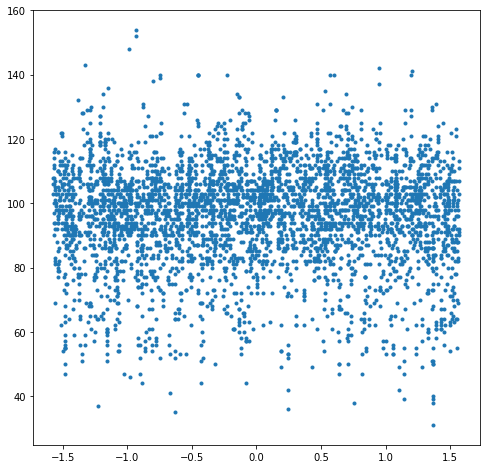

In [5]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

# Plot the comparison
ax.plot(df['phase'], df['depth'], '.')

plt.show()

In [6]:
session.close()